# Import

In [31]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
from skimage.io import imread
import rasterio
from tqdm import tqdm
import skimage.transform
import math
from skimage.morphology import skeletonize
import sknw
import cv2
from collections import Counter
from skimage.draw import circle
%matplotlib inline

# Glob

In [32]:
root = 'data'
train_folders1 = ['AOI_2_Vegas_Roads_Train', 'AOI_3_Paris_Roads_Train', 'AOI_4_Shanghai_Roads_Train', 'AOI_5_Khartoum_Roads_Train']
bit8_folders2 = ['RGB-PanSharpen_8bit']#, 'PAN_8bit', 'MUL-PanSharpen_8bit'] #, 'MUL_8bit'
mask_folders2_train = ['MUL-PanSharpen_layered_mask',
                       'MUL-PanSharpen_mask',
                       'MUL-PanSharpen_width_mask',
                       'PAN_mask',
                       'RGB-PanSharpen_mask',
                       'ln34_mul_ps_vegetation_aug_dice_predict_train',
                       'ln34_wide_masks_mul_ps_vegetation_aug_dice_predict_train']
mask_folders2_train_pad = ['ln34_mul_ps_vegetation_aug_dice_predict_train_pad',
                       'ln34_wide_masks_mul_ps_8channel_aug_dice_predict_pad',
                       'ln34_wide_masks_mul_ps_vegetation_aug_dice_predict_train_pad']

test_folders1 = ['AOI_2_Vegas_Roads_Test_Public', 
                 'AOI_3_Paris_Roads_Test_Public', 
                 'AOI_4_Shanghai_Roads_Test_Public', 
                 'AOI_5_Khartoum_Roads_Test_Public']
mask_folders2_test = ['ln34_mul_ps_8channel_aug_dice_predict', 
                      'ln34_mul_ps_naive1_aug_dice_predict', 
                      'ln34_mul_ps_naive2_aug_dice_predict', 
                      'ln34_mul_ps_urban_aug_dice_predict', 
                      'ln34_mul_ps_vegetation_aug_dice_predict', 
                      'ln34_wide_masks_mul_ps_8channel_aug_dice_predict', 
                      'ln34_wide_masks_mul_ps_naive2_aug_dice_predict', 
                      'ln34_wide_masks_mul_ps_urban_aug_dice_predict', 
                      'ln34_wide_masks_mul_ps_vegetation_aug_dice_predict']
mask_folders2_test_pad = ['ln34_mul_ps_8channel_aug_dice_predict_pad', 
                      'ln34_mul_ps_naive1_aug_dice_predict_pad', 
                      'ln34_mul_ps_naive2_aug_dice_predict_pad', 
                      'ln34_mul_ps_urban_aug_dice_predict_pad', 
                      'ln34_mul_ps_vegetation_aug_dice_predict_pad', 
                      'ln34_wide_masks_mul_ps_8channel_aug_dice_predict_pad', 
                      'ln34_wide_masks_mul_ps_naive2_aug_dice_predict_pad', 
                      'ln34_wide_masks_mul_ps_urban_aug_dice_predict_pad', 
                      'ln34_wide_masks_mul_ps_vegetation_aug_dice_predict_pad']

In [33]:
globdf = pd.DataFrame()
for train_folder in train_folders1:
    
    for bit8_folder in bit8_folders2:
        local = pd.DataFrame()
        bit8_folder_path = '{}/{}/{}'.format(root, train_folder, bit8_folder)
        local['bit8_img'] = glob.glob('{}/*.tif'.format(bit8_folder_path))
        local['bit8_folder'] = bit8_folder
        local['train_folder'] = train_folder
        globdf = pd.concat([globdf, local],ignore_index = True)
        del local

globdf_masks = pd.DataFrame()
for train_folder in train_folders1:
    
    for mask_folder_train in mask_folders2_train:
        local = pd.DataFrame()
        mask_folder_train_path = '{}/{}/{}'.format(root, train_folder, mask_folder_train)
        local['mask_img'] = glob.glob('{}/*.jpg'.format(mask_folder_train_path))
        local['mask_folder_train'] = mask_folder_train
        local['train_folder'] = train_folder
        globdf_masks = pd.concat([globdf_masks, local],ignore_index = True)
        del local

globdf_masks_pad = pd.DataFrame()
for train_folder in train_folders1:
    
    for mask_folder_train in mask_folders2_train_pad:
        local = pd.DataFrame()
        mask_folder_train_path = '{}/{}/{}'.format(root, train_folder, mask_folder_train)
        local['mask_img'] = glob.glob('{}/*.jpg'.format(mask_folder_train_path))
        local['mask_folder_train'] = mask_folder_train
        local['train_folder'] = train_folder
        globdf_masks_pad = pd.concat([globdf_masks_pad, local],ignore_index = True)
        del local
        
globdf_test = pd.DataFrame()
for test_folder in test_folders1:
    
    for bit8_folder in bit8_folders2:
        local = pd.DataFrame()
        bit8_folder_path = '{}/{}/{}'.format(root, test_folder, bit8_folder)
        local['bit8_img'] = glob.glob('{}/*.tif'.format(bit8_folder_path))
        local['bit8_folder'] = bit8_folder
        local['test_folder'] = test_folder
        globdf_test = pd.concat([globdf_test, local],ignore_index = True)
        del local
        
globdf_masks_test = pd.DataFrame()
for test_folder in test_folders1:
    
    
    for mask_folder_test in mask_folders2_test:
        local = pd.DataFrame()
        mask_folder_test_path = '{}/{}/{}'.format(root, test_folder, mask_folder_test)
        local['mask_img'] = glob.glob('{}/*.jpg'.format(mask_folder_test_path))
        local['mask_folder_test'] = mask_folder_test
        local['test_folder'] = test_folder
        globdf_masks_test = pd.concat([globdf_masks_test, local],ignore_index = True)
        del local

globdf_masks_test_pad = pd.DataFrame()
for test_folder in test_folders1:
    
    
    for mask_folder_test in mask_folders2_test_pad:
        local = pd.DataFrame()
        mask_folder_test_path = '{}/{}/{}'.format(root, test_folder, mask_folder_test)
        local['mask_img'] = glob.glob('{}/*.jpg'.format(mask_folder_test_path))
        local['mask_folder_test'] = mask_folder_test
        local['test_folder'] = test_folder
        globdf_masks_test_pad = pd.concat([globdf_masks_test_pad, local],ignore_index = True)
        del local

In [34]:
# test
globdf_masks_test['mask_name'] = globdf_masks_test['mask_img'].apply(lambda x: x.split('/')[3])
globdf_test['bit8_name'] = globdf_test['bit8_img'].apply(lambda x: x.split('/')[3])

globdf_masks_test['img_id'] = globdf_masks_test['mask_name'].apply(lambda x: x[x.find('AOI'):x.find('.')])
globdf_test['img_id'] = globdf_test['bit8_name'].apply(lambda x: x[x.find('AOI'):x.find('.')])

globdf_masks_test_pad['mask_name'] = globdf_masks_test_pad['mask_img'].apply(lambda x: x.split('/')[3])
globdf_masks_test_pad['img_id'] = globdf_masks_test_pad['mask_name'].apply(lambda x: x[x.find('AOI'):x.find('.')])

#train
globdf_masks['mask_name'] = globdf_masks['mask_img'].apply(lambda x: x.split('/')[3])
globdf['bit8_name'] = globdf['bit8_img'].apply(lambda x: x.split('/')[3])

globdf_masks['img_id'] = globdf_masks['mask_name'].apply(lambda x: x[x.find('AOI'):x.find('.')])
globdf['img_id'] = globdf['bit8_name'].apply(lambda x: x[x.find('AOI'):x.find('.')])

globdf_masks_pad['mask_name'] = globdf_masks_pad['mask_img'].apply(lambda x: x.split('/')[3])
globdf_masks_pad['img_id'] = globdf_masks_pad['mask_name'].apply(lambda x: x[x.find('AOI'):x.find('.')])

In [35]:
#test
globdf_test_pad = globdf_test.merge(globdf_masks_test_pad, how = 'left', on = ['test_folder', 'img_id'])
globdf_test_notpad = globdf_test.merge(globdf_masks_test, how = 'left', on = ['test_folder', 'img_id'])
#train
globdf_train_pad = globdf.merge(globdf_masks_pad, how = 'left', on = ['train_folder', 'img_id'])
globdf_train_notpad = globdf.merge(globdf_masks, how = 'left', on = ['train_folder', 'img_id'])

# sknw

In [36]:
def simplify_edge(ps: np.ndarray, max_distance=3):
    """
    Combine multiple points of graph edges to line segments
    so distance from points to segments <= max_distance
    :param ps: array of points in the edge, including node coordinates
    :param max_distance: maximum distance, if exceeded new segment started
    :return: ndarray of new nodes coordinates
    """
    res_points = []
    cur_idx = 0
    # combine points to the single line while distance from the line to any point < max_distance
    for i in range(1, len(ps) - 1):
        segment = ps[cur_idx:i + 1, :] - ps[cur_idx, :]
        angle = -math.atan2(segment[-1, 1], segment[-1, 0])
        ca = math.cos(angle)
        sa = math.sin(angle)
        # rotate all the points so line is alongside first column coordinate
        # and the second col coordinate means the distance to the line
        segment_rotated = np.array([[ca, -sa], [sa, ca]]).dot(segment.T)
        distance = np.max(np.abs(segment_rotated[1, :]))
        if distance > max_distance:
            res_points.append(ps[cur_idx, :])
            cur_idx = i
    if len(res_points) == 0:
        res_points.append(ps[0, :])
    res_points.append(ps[-1, :])

    return np.array(res_points)

In [37]:
def simplify_graph(graph, max_distance=2):
    """
    :type graph: MultiGraph
    """
    all_segments = []
    for (s, e) in graph.edges():
        for _, val in graph[s][e].items():
            ps = val['pts']
            full_segments = np.row_stack([
                graph.node[s]['o'],
                ps,
                graph.node[e]['o']
            ])

            segments = simplify_edge(full_segments, max_distance=max_distance)
            all_segments.append(segments)

    return all_segments

In [38]:
def segment_to_linestring(segment):
    
    if len(segment) < 2:
        return []
    
    linestring = 'LINESTRING ({})'
    sublinestring = ''
        
    for i, node in enumerate(segment):
        
        if i == 0:
            sublinestring = sublinestring + '{:.1f} {:.1f}'.format(node[1], node[0])
        else:
            if node[0] == segment[i - 1][0] and node[1] == segment[i - 1][1]:
                if len(segment) == 2:
                    return []
                continue
            if i > 1 and node[0] == segment[i - 2][0] and node[1] == segment[i - 2][1]:
                continue
            sublinestring = sublinestring + ', {:.1f} {:.1f}'.format(node[1], node[0])
    linestring = linestring.format(sublinestring)
    return linestring

In [39]:
def segmets_to_linestrings(segments):
    linestrings = []
    for segment in segments:
        linestring = segment_to_linestring(segment)
        if len(linestring) > 0:
            linestrings.append(linestring)
    if len(linestrings) == 0:
        linestrings = ['LINESTRING EMPTY']
    return linestrings

In [40]:
def process_masks(mask_paths):
    lnstr_df = pd.DataFrame()
    with tqdm(total=len(mask_paths)) as pbar:
        for msk_pth in mask_paths:
            #print(msk_pth)
            msk = imread(msk_pth)
            msk = msk[6:1306, 6:1306]
            msk_nme = msk_pth.split('/')[3]
            img_id = msk_nme[msk_nme.find('AOI'):msk_nme.find('.')]

            # open and skeletonize
            thresh = 30
            binary = (msk > thresh)*1
            
            ske = skeletonize(binary).astype(np.uint16)

            # build graph from skeleton
            graph = sknw.build_sknw(ske, multi=True)
            segments = simplify_graph(graph)

            linestrings = segmets_to_linestrings(segments)
            local = pd.DataFrame()
            local['WKT_Pix'] = linestrings
            local['ImageId'] = img_id

            lnstr_df = pd.concat([lnstr_df, local], ignore_index = True)
            pbar.update(1)
    return lnstr_df

In [41]:
def draw_mask(circle_size,
              line_width,
              ls_list,
              mask_size
             ):

    mask = np.zeros((mask_size, mask_size), dtype=np.uint8)
    all_points = []
    
    for line in ls_list:

        points_xy = line
        all_points.extend(points_xy)
        for i,[x,y] in enumerate(points_xy):
            
            if i-1>-1:
                prev_x = int(float(points_xy[i-1][0]))
                prev_y = int(float(points_xy[i-1][1]))
                mask = cv2.line(mask,(prev_x,prev_y),(int(float(x)),int(float(y))),(150),line_width)
                
        all_points_text = [(str(point[0])+' '+str(point[1])) for point in all_points]
        count_dict =  Counter(all_points_text)

        for key, value in count_dict.items():
            if(value>1):
                x,y = key.split()
                rr, cc = circle(int(float(y)), int(float(x)), circle_size)
                #mask[rr.clip(min=0,max=mask_size-1), cc.clip(min=0,max=mask_size-1)] = 255
    return mask

In [42]:
def spl_to_points(values_list):
    new_list = []
    for value in values_list:
        point = []
        point = value.split()
        new_list.append(point)
    return new_list

def lstrs_util(lstrs):
    
    lstrs['values'] = lstrs.WKT_Pix.apply(lambda x: x[x.find('(') + 1: x.find(')')])
    lstrs['values_list'] = lstrs['values'].apply(lambda x: x.split(', '))
    lstrs['points_list'] = lstrs['values_list'].apply(spl_to_points)
    return lstrs

# Check sknw

In [43]:
globdf_test_narrow_vegetation = globdf_test_pad[globdf_test_pad['mask_folder_test'] == 'ln34_mul_ps_vegetation_aug_dice_predict_pad'].copy()

In [44]:
df_sample = globdf_test_narrow_vegetation.sample(n=1, random_state = 0)

In [45]:
mask_path = df_sample.mask_img.values[0]
mask = imread(mask_path)
mask = mask[6:1306, 6:1306]
thresh = 30
binary = (mask > thresh)*1
ske = skeletonize(binary).astype(np.uint16)
graph = sknw.build_sknw(ske, multi=True)
segments = simplify_graph(graph)

In [46]:
lstrs = process_masks(df_sample.mask_img.values)
lstrs

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


WKT_Pix              ImageId
0   LINESTRING (449.0 5.0, 444.0 12.0, 417.0 74.0,...  AOI_2_Vegas_img1353
1               LINESTRING (1044.0 8.0, 1041.8 142.0)  AOI_2_Vegas_img1353
2               LINESTRING (1216.0 8.0, 1218.2 362.0)  AOI_2_Vegas_img1353
3              LINESTRING (620.0 141.0, 1041.8 142.0)  AOI_2_Vegas_img1353
4             LINESTRING (1041.8 142.0, 1041.8 367.0)  AOI_2_Vegas_img1353
5   LINESTRING (1218.2 362.0, 1212.0 943.0, 1207.0...  AOI_2_Vegas_img1353
6             LINESTRING (1218.2 362.0, 1295.0 366.0)  AOI_2_Vegas_img1353
7   LINESTRING (1041.8 367.0, 632.0 369.0, 538.0 3...  AOI_2_Vegas_img1353
8             LINESTRING (1041.8 367.0, 1037.8 927.0)  AOI_2_Vegas_img1353
9               LINESTRING (151.0 404.0, 164.3 414.3)  AOI_2_Vegas_img1353
10  LINESTRING (164.3 414.3, 176.0 462.0, 195.8 53...  AOI_2_Vegas_img1353
11  LINESTRING (195.8 532.0, 255.0 526.0, 375.0 52...  AOI_2_Vegas_img1353
12  LINESTRING (195.8 532.0, 179.0 541.0, 100.0 57...  AOI_2_Vegas_img1353
13  LINESTRING (759.0 585.0, 727.0 615.0, 707.8 63...  AOI_2_Vegas_img1353
14  LINESTRING (707.8 638.0, 716.0 654.0, 757.0 69...  AOI_2_Vegas_img1353
15              LINESTRING (549.0 772.8, 519.0 788.0)  AOI_2_Vegas_img1353
16  LINESTRING (549.0 772.8, 541.0 758.0, 503.0 73...  AOI_2_Vegas_img1353
17  LINESTRING (549.0 772.8, 570.0 783.0, 595.0 81...  AOI_2_Vegas_img1353
18    LINESTRING (84.0 851.8, 75.0 865.0, 70.3 937.3)  AOI_2_Vegas_img1353
19               LINESTRING (84.0 851.8, 111.0 857.0)  AOI_2_Vegas_img1353
20              LINESTRING (541.0 856.0, 483.0 857.0)  AOI_2_Vegas_img1353
21              LINESTRING (443.0 857.0, 472.0 857.0)  AOI_2_Vegas_img1353
22              LINESTRING (476.0 857.0, 481.0 857.0)  AOI_2_Vegas_img1353
23           LINESTRING (1037.8 927.0, 1037.5 1081.5)  AOI_2_Vegas_img1353
24  LINESTRING (70.3 937.3, 291.0 940.0, 305.0 949...  AOI_2_Vegas_img1353
25               LINESTRING (70.3 937.3, 75.0 1072.8)  AOI_2_Vegas_img1353
26             LINESTRING (626.7 937.7, 627.7 1006.3)  AOI_2_Vegas_img1353
27  LINESTRING (626.7 937.7, 389.0 939.0, 353.8 99...  AOI_2_Vegas_img1353
28             LINESTRING (151.0 984.0, 245.0 1001.0)  AOI_2_Vegas_img1353
29              LINESTRING (329.3 988.7, 353.8 990.0)  AOI_2_Vegas_img1353
..                                                ...                  ...
31  LINESTRING (353.8 990.0, 367.0 999.0, 411.0 10...  AOI_2_Vegas_img1353
32            LINESTRING (451.0 1004.0, 627.7 1006.3)  AOI_2_Vegas_img1353
33            LINESTRING (627.7 1006.3, 628.0 1079.0)  AOI_2_Vegas_img1353
34               LINESTRING (0.0 1064.0, 75.0 1072.8)  AOI_2_Vegas_img1353
35  LINESTRING (75.0 1072.8, 144.0 1077.0, 380.3 1...  AOI_2_Vegas_img1353
36           LINESTRING (628.0 1079.0, 1037.5 1081.5)  AOI_2_Vegas_img1353
37            LINESTRING (628.0 1079.0, 380.3 1082.3)  AOI_2_Vegas_img1353
38  LINESTRING (1037.5 1081.5, 1221.0 1085.0, 1299...  AOI_2_Vegas_img1353
39          LINESTRING (1037.5 1081.5, 1036.6 1129.0)  AOI_2_Vegas_img1353
40            LINESTRING (380.3 1082.3, 377.0 1133.0)  AOI_2_Vegas_img1353
41          LINESTRING (1036.6 1129.0, 1045.0 1299.0)  AOI_2_Vegas_img1353
42          LINESTRING (1036.6 1129.0, 1292.0 1134.0)  AOI_2_Vegas_img1353
43           LINESTRING (1036.6 1129.0, 713.3 1135.3)  AOI_2_Vegas_img1353
44              LINESTRING (8.0 1129.0, 377.0 1133.0)  AOI_2_Vegas_img1353
45            LINESTRING (377.0 1133.0, 378.2 1187.0)  AOI_2_Vegas_img1353
46            LINESTRING (377.0 1133.0, 713.3 1135.3)  AOI_2_Vegas_img1353
47            LINESTRING (713.3 1135.3, 721.0 1297.0)  AOI_2_Vegas_img1353
48              LINESTRING (20.0 1146.0, 20.0 1149.0)  AOI_2_Vegas_img1353
49  LINESTRING (378.2 1187.0, 648.0 1190.0, 655.8 ...  AOI_2_Vegas_img1353
50            LINESTRING (378.2 1187.0, 377.2 1249.0)  AOI_2_Vegas_img1353
51              LINESTRING (20.0 1194.0, 21.0 1201.0)  AOI_2_Vegas_img1353
52            LINESTRING (377.2 1249.0, 655.8 1251.0)  AOI_2_Vegas_img1

In [47]:
lstrs_new = lstrs_util(lstrs)

In [48]:
imgids = df_sample['img_id'].unique()
bit8_tiff_paths = df_sample.bit8_img.unique()
mask_paths = df_sample.mask_img.unique()

100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


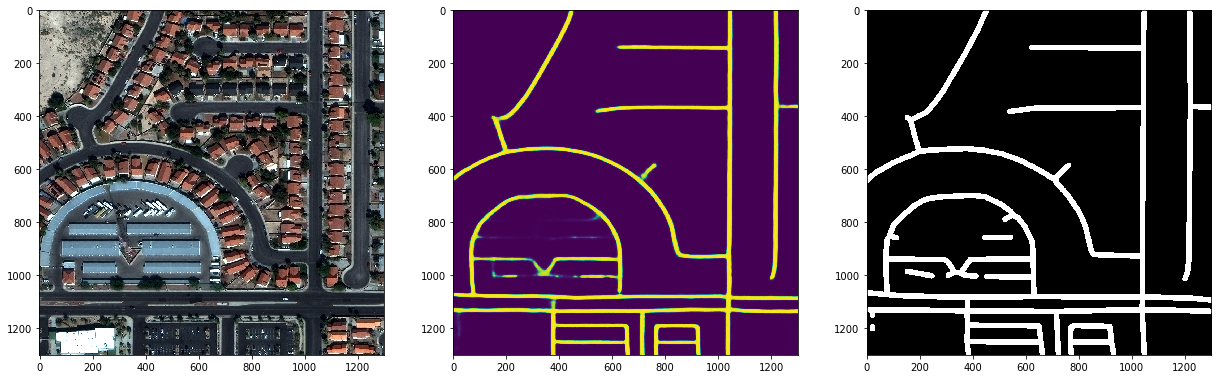

In [49]:
with tqdm(total = len(imgids)) as pbar:
    for im, b8, mskp in zip(imgids, bit8_tiff_paths, mask_paths):
        msk = draw_mask(20, 20, list(lstrs_new[(lstrs_new['WKT_Pix'] != 'LINESTRING EMPTY') & (lstrs_new['ImageId'] == im)]['points_list']), 1300)
        f, axes = plt.subplots(1, 3, figsize=(21, 7))

        with rasterio.open(b8, 'r') as src:
            img = np.empty((src.width, src.height, src.count))
            img[:, :, 0] = src.read(1)
            img[:, :, 1] = src.read(2)
            img[:, :, 2] = src.read(3)

        img += -img.min()
        img *= (1/img.max())

        mask = imread(mskp)
        mask = mask[6:1306, 6:1306]


        axes[0].imshow(img)
        axes[1].imshow(mask)  
        axes[2].imshow(msk, cmap=plt.cm.gray)
        pbar.update(1)

# Train Linestrings

In [50]:
globdf_train_narrow_vegetation = globdf_train_pad[globdf_train_pad['mask_folder_train'] == 'ln34_mul_ps_vegetation_aug_dice_predict_train_pad'].copy()

In [51]:
lstrs_narrow_train = process_masks(globdf_train_narrow_vegetation.mask_img)
lstrs_narrow_train.head()

100%|██████████| 2549/2549 [11:30<00:00,  4.17it/s]


WKT_Pix             ImageId
0                 LINESTRING (767.0 5.0, 770.7 92.7)  AOI_2_Vegas_img698
1                 LINESTRING (981.0 6.0, 986.0 91.0)  AOI_2_Vegas_img698
2  LINESTRING (986.0 91.0, 1018.0 93.0, 1292.0 95.0)  AOI_2_Vegas_img698
3                LINESTRING (986.0 91.0, 775.7 96.3)  AOI_2_Vegas_img698
4                  LINESTRING (770.7 92.7, 5.0 95.0)  AOI_2_Vegas_img698

In [52]:
len(lstrs_narrow_train[lstrs_narrow_train['WKT_Pix'] == 'LINESTRING EMPTY'])

90

In [53]:
lstrs_narrow_train = lstrs_narrow_train[['ImageId', 'WKT_Pix']].copy()
lstrs_narrow_train = lstrs_narrow_train.drop_duplicates()

lstrs_narrow_train.to_csv('solutions/lstrs_narrow_train_vegetation_pad_dmytro_multi.csv', index = False)

In [54]:
len(lstrs_narrow_train)

122598

# TEST Linestrings

In [55]:
globdf_test_narrow_vegetation = globdf_test_pad[globdf_test_pad['mask_folder_test'] == 'ln34_mul_ps_vegetation_aug_dice_predict_pad'].copy()

In [56]:
lstrs_test = process_masks(globdf_test_narrow_vegetation.mask_img)
lstrs_test

100%|██████████| 928/928 [03:50<00:00,  5.54it/s]


WKT_Pix  \
0                     LINESTRING (173.0 6.0, 170.0 82.6)   
1                     LINESTRING (491.0 7.0, 488.5 86.0)   
2                   LINESTRING (1089.0 7.0, 1083.5 95.5)   
3                   LINESTRING (1272.0 7.0, 1270.7 94.7)   
4                        LINESTRING (0.0 75.0, 6.0 82.0)   
5      LINESTRING (170.0 82.6, 151.0 869.0, 142.0 120...   
6                      LINESTRING (170.0 82.6, 6.0 82.0)   
7                    LINESTRING (170.0 82.6, 488.5 86.0)   
8                        LINESTRING (6.0 82.0, 3.0 86.0)   
9                   LINESTRING (488.5 86.0, 482.2 362.0)   
10                  LINESTRING (488.5 86.0, 1083.5 95.5)   
11                 LINESTRING (1083.5 95.5, 1270.7 94.7)   
12                LINESTRING (1083.5 95.5, 1077.2 400.0)   
13                LINESTRING (1270.7 94.7, 1298.0 114.0)   
14                 LINESTRING (482.2 362.0, 477.2 502.0)   
15                 LINESTRING (482.2 362.0, 848.0 367.0)   
16               LINESTRING (1077.2 400.0, 1065.2 891.0)   
17     LINESTRING (1077.2 400.0, 1238.0 405.0, 1247.0...   
18                 LINESTRING (489.0 500.0, 477.2 502.0)   
19                 LINESTRING (477.2 502.0, 471.2 801.0)   
20                LINESTRING (471.2 801.0, 465.2 1057.0)   
21                 LINESTRING (471.2 801.0, 834.0 805.0)   
22               LINESTRING (1296.0 888.0, 1292.8 892.0)   
23              LINESTRING (1065.2 891.0, 1055.7 1098.7)   
24               LINESTRING (1065.2 891.0, 1292.8 892.0)   
25               LINESTRING (1292.8 892.0, 1296.0 897.0)   
26               LINESTRING (465.2 1057.0, 822.0 1062.0)   
27               LINESTRING (465.2 1057.0, 457.0 1290.0)   
28             LINESTRING (1078.0 1097.0, 1077.8 1102.8)   
29             LINESTRING (1055.7 1098.7, 1072.8 1108.0)   
...                                                  ...   
42382  LINESTRING (1214.0 6.0, 1218.0 156.0, 1222.0 3...   
42383  LINESTRING (353.0 11.0, 354.0 68.0, 341.0 95.0...   
42384              LINESTRING (666.0 205.0, 669.0 204.0)   
42385              LINESTRING (666.0 205.0, 657.0 227.0)   
42386  LINESTRING (643.0 268.0, 632.0 300.0, 621.0 42...   
42387            LINESTRING (1255.0 412.0, 1225.7 415.3)   
42388  LINESTRING (1255.0 412.0, 1260.0 420.0, 1265.0...   
42389            LINESTRING (1220.0 413.8, 1225.7 415.3)   
42390  LINESTRING (1220.0 413.8, 1198.0 418.0, 1125.0...   
42391  LINESTRING (1225.7 415.3, 1228.0 442.0, 1225.0...   
42392  LINESTRING (621.0 428.8, 398.0 438.0, 54.0 448...   
42393            LINESTRING (1207.0 601.0, 1232.8 602.0)   
42394            LINESTRING (1232.8 602.0, 1238.0 779.0)   
42395            LINESTRING (1194.0 602.0, 1197.0 602.0)   
42396              LINESTRING (636.0 722.0, 637.0 738.0)   
42397            LINESTRING (1238.0 779.0, 1236.8 784.0)   
42398            LINESTRING (1236.8 784.0, 1254.0 799.0)   
42399            LINESTRING (1236.8 784.0, 1232.0 792.2)   
42400              LINESTRING (642.0 784.0, 642.0 812.8)   
42401  LINESTRING (1232.0 792.2, 1186.0 794.0, 954.0 ...   
42402           LINESTRING (1232.0 792.2, 1243.7 1042.3)   
42403  LINESTRING (1270.0 807.0, 1276.0 816.0, 1280.0...   
42404  LINESTRING (642.0 812.8, 511.0 816.0, 358.0 82...   
42405  LINESTRING (1243.7 1042.3, 1110.0 1044.0, 890....   
42406  LINESTRING (1243.7 1042.3, 1247.0 1062.0, 1250...   
42407  LINESTRING (1250.0 1254.0, 1222.0 1251.0, 1181...   
42408          LINESTRING (1250.0 1254.0, 1258.0 1299.0)   
42409            LINESTRING (782.0 1267.0, 781.0 1275.8)   
42410            LINESTRING (877.0 1268.8, 781.0 1275.8)   
42411  LINESTRING (781.0 1275.8, 721.0 1276.0, 636.0 ...   

                     ImageId  
0         AOI_2_Vegas_img785  
1         AOI_2_Vegas_img785  
2         AOI_2_Vegas_img785  
3         AOI_2_Vegas_img785  
4         AOI_2_Vegas_img785  
5         AOI_2_Vegas_img785  
6         AOI_2_Vegas_img785  
7         AOI_2_Vegas_img785  
8         AOI_2_Vegas_img785  
9         AOI_2_Ve

In [57]:
len(lstrs_test[lstrs_test['WKT_Pix'] == 'LINESTRING EMPTY'])

107

In [58]:
lstrs_test = lstrs_test[['ImageId', 'WKT_Pix']].copy()
lstrs_test = lstrs_test.drop_duplicates()

lstrs_test.to_csv('solutions/lstrs_narrow_test_vegetation_pad_dmytro_multi.csv', index = False)

# Checking train

In [31]:
def make_visual_train(globdf_masks, masks_folder, sample_size, globdf_gt, gt_folder, lstrs, folder_to_save_to):
    new_lstrs = lstrs_util(lstrs)
    globdf_masks_filtered = globdf_masks[globdf_masks['mask_folder_train'] == masks_folder].copy()
    globdf_gt_filtered = globdf_gt[globdf_gt['mask_folder_train'] == gt_folder].copy()
    globdf_gt_filtered.rename(columns = {'mask_img':'gt_img'}, inplace = True)
    globdf_masks_filtered = globdf_masks_filtered.merge(globdf_gt_filtered[['img_id', 'gt_img']], how = 'inner', on = 'img_id')
    df_sample = globdf_masks_filtered.sample(n=sample_size, random_state = 0)
    imgids = df_sample['img_id'].unique()
    bit8_tiff_paths = df_sample.bit8_img.unique()
    mask_paths = df_sample.mask_img.unique()
    mask_gts = df_sample.gt_img.unique()
    
    with tqdm(total = len(imgids)) as pbar:
        for im, b8, mskp, gt in zip(imgids, bit8_tiff_paths, mask_paths, mask_gts):
            msk = draw_mask(20, 20, list(new_lstrs[(new_lstrs['WKT_Pix'] != 'LINESTRING EMPTY') & (new_lstrs['ImageId'] == im)]['points_list']), 1300)
            f, axes = plt.subplots(2, 2, figsize=(14, 14))

            with rasterio.open(b8, 'r') as src:
                img = np.empty((src.width, src.height, src.count))
                img[:, :, 0] = src.read(1)
                img[:, :, 1] = src.read(2)
                img[:, :, 2] = src.read(3)

            img += -img.min()
            img *= (1/img.max())

            mask = imread(mskp)
            mask = mask[6:1306, 6:1306]

            mask_gt = imread(gt)

            axes[0, 0].imshow(img)
            axes[0, 0].set_title('original', fontsize=20)
            axes[0, 1].imshow(mask)  
            axes[0, 1].set_title('8 channel mask', fontsize=20)
            axes[1, 0].imshow(mask_gt)  
            axes[1, 0].set_title('gt mask', fontsize=20)
            axes[1, 1].imshow(msk, cmap=plt.cm.gray)
            axes[1, 1].set_title('from linestring', fontsize=20)

            plt.savefig('{}/{}.png'.format(folder_to_save_to, im), bbox_inches='tight')
            plt.gcf().clear()
            pbar.update(1)

In [34]:
make_visual_train(globdf_masks = globdf_train_pad, 
                  masks_folder = 'ln34_mul_ps_vegetation_aug_dice_predict_train_pad', 
                  sample_size = 100, 
                  globdf_gt = globdf_train_notpad, 
                  gt_folder = 'RGB-PanSharpen_mask', 
                  lstrs = lstrs_narrow_train, 
                  folder_to_save_to = 'narrow_veg_pad_dmytro_check_multi')

 20%|██        | 20/100 [00:22<01:24,  1.06s/it]/opt/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 100/100 [01:45<00:00,  1.22s/it]


# Look thru solutions

## Baseline

In [2]:
import pandas as pd

solution_df = pd.read_csv('../solutions/score_dmytro_train_narrow_veg_pad_multi.csv')
solution_df['cty'] = solution_df['img'].apply(lambda x: x.split('_img')[0])

In [2]:
solution_df.head()

img    t→p    p→t  score
0     AOI_2_Vegas_img1  0.845  0.620  0.715
1    AOI_2_Vegas_img10  0.982  0.974  0.978
2   AOI_2_Vegas_img100  0.827  0.721  0.771
3  AOI_2_Vegas_img1001  0.697  0.688  0.693
4  AOI_2_Vegas_img1002  0.411  0.596  0.486

In [10]:
!ls -ls ../data/AOI_2_Vegas_Roads_Test_Public/MUL-PanSharpen_8bit/ | wc -l
!ls -ls ../data/AOI_3_Paris_Roads_Test_Public/MUL-PanSharpen_8bit/ | wc -l
!ls -ls ../data/AOI_4_Shanghai_Roads_Test_Public/MUL-PanSharpen_8bit/ | wc -l
!ls -ls ../data/AOI_5_Khartoum_Roads_Test_Public/MUL-PanSharpen_8bit/ | wc -l

331
105
400
96


In [8]:
import numpy as np

table = pd.pivot_table(solution_df,
                    index=['cty'],
                    values=["t→p","p→t","score"],
                    aggfunc={np.mean,len},
                    fill_value=0)

table

p→t           score             t→p          
                 len      mean   len      mean   len      mean
cty                                                           
AOI_2_Vegas      989  0.773161   989  0.750043   989  0.762303
AOI_3_Paris      310  0.591008   310  0.452817   310  0.443969
AOI_4_Shanghai  1198  0.631102  1198  0.521480  1198  0.504369
AOI_5_Khartoum   283  0.685124   283  0.520212   283  0.460926

In [ ]:
pivot_table[]

In [3]:
import numpy as np
import math
from skimage.io import imread
import matplotlib.pyplot as plt
import skimage.morphology
import sknw
import random 
import networkx as nx

DILATION_SIZE = 4
MAX_DISTANCE_FROM_LINE_TO_SPLIT = 2
CLIP_THRESHOLD = 0.3


def simplify_edge(ps: np.ndarray, max_distance=3):
    """
    Combine multiple points of graph edges to line segments
    so distance from points to segments <= max_distance
    :param ps: array of points in the edge, including node coordinates
    :param max_distance: maximum distance, if exceeded new segment started
    :return: ndarray of new nodes coordinates
    """
    res_points = []
    cur_idx = 0
    # combine points to the single line while distance from the line to any point < max_distance
    for i in range(1, len(ps) - 1):
        segment = ps[cur_idx:i + 1, :] - ps[cur_idx, :]
        angle = -math.atan2(segment[-1, 1], segment[-1, 0])
        ca = math.cos(angle)
        sa = math.sin(angle)
        # rotate all the points so line is alongside first column coordinate
        # and the second col coordinate means the distance to the line
        segment_rotated = np.array([[ca, -sa], [sa, ca]]).dot(segment.T)
        distance = np.max(np.abs(segment_rotated[1, :]))
        if distance > max_distance:
            res_points.append(ps[cur_idx, :])
            cur_idx = i
    if len(res_points) == 0:
        res_points.append(ps[0, :])
    res_points.append(ps[-1, :])

    return np.array(res_points)

def draw_original_graph(graph):
    # draw original points in green/red
    for (s, e) in graph.edges():
        for _, val in graph[s][e].items():
            ps = val['pts']
            plt.plot(ps[:, 1], ps[:, 0], 'green')

            for node in (graph.node[s], graph.node[e]):
                plt.plot(node['o'][1], node['o'][0], 'r.')

def simplify_graph(graph, max_distance=2):
    """
    :type graph: MultiGraph
    """
    all_segments = []
    for (s, e) in graph.edges():
        for _, val in graph[s][e].items():
            ps = val['pts']
            full_segments = np.row_stack([
                graph.node[s]['o'],
                ps,
                graph.node[e]['o']
            ])

            segments = simplify_edge(full_segments, max_distance=max_distance)
            all_segments.append(segments)

    return all_segments

In [350]:
import networkx as nx

unconnected_threshold = 2

subgraph_len_dict = {i:len(nx.shortest_path(graph_0,i).keys()) for i in range(0,max(graph_0.nodes()))  }

for graph_node, subgraph_len in subgraph_len_dict.items():
    if subgraph_len <= unconnected_threshold:
        graph_0.remove_node(graph_node)
        

In [352]:
len(graph_0.nodes())

195

In [340]:
subgraph_len_dict

{0: 3,
 1: 2,
 2: 2,
 3: 2,
 4: 2,
 5: 2,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 2,
 11: 2,
 12: 3,
 13: 3,
 14: 2,
 15: 139,
 16: 139,
 17: 139,
 18: 2,
 19: 2,
 20: 2,
 21: 2,
 22: 2,
 23: 2,
 24: 3,
 25: 3,
 26: 2,
 27: 2,
 28: 3,
 29: 3,
 30: 139,
 31: 139,
 32: 139,
 33: 139,
 34: 139,
 35: 139,
 36: 139,
 37: 139,
 38: 139,
 39: 2,
 40: 2,
 41: 139,
 42: 3,
 43: 3,
 44: 139,
 45: 139,
 46: 139,
 47: 139,
 48: 139,
 49: 139,
 50: 139,
 51: 139,
 52: 139,
 53: 139,
 54: 139,
 55: 139,
 56: 139,
 57: 139,
 58: 139,
 59: 139,
 60: 139,
 61: 139,
 62: 139,
 63: 139,
 64: 139,
 65: 139,
 66: 139,
 67: 139,
 68: 139,
 69: 139,
 70: 139,
 71: 139,
 72: 139,
 73: 139,
 74: 139,
 75: 139,
 76: 139,
 77: 139,
 78: 139,
 79: 139,
 80: 139,
 81: 139,
 82: 139,
 83: 139,
 84: 139,
 85: 139,
 86: 139,
 87: 139,
 88: 139,
 89: 139,
 90: 139,
 91: 8,
 92: 8,
 93: 139,
 94: 8,
 95: 139,
 96: 139,
 97: 139,
 98: 139,
 99: 139,
 100: 139,
 101: 139,
 102: 139,
 103: 8,
 104: 139,
 105: 139,
 106: 2,
 107:

In [ ]:
nodes = nx.shortest_path(u,'B').keys()

In [26]:
!ls '../data/AOI_4_Shanghai_Roads_Train/RGB-PanSharpen_8bit/RGB-PanSharpen_AOI_4_Shanghai_img10.tif'

ls: cannot access '../data/AOI_4_': No such file or directory


In [ ]:
../data/AOI_4_Shanghai_Roads_Train/RGB-PanSharpen_mask/

In [47]:
!ls $orig_img

../data/AOI_4_Shanghai_Roads_Train/RGB-PanSharpen_8bit/RGB-PanSharpen_AOI_4_Shanghai_img646.tif


In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

solution_df[solution_df.cty == 'AOI_2_Vegas'].plot(kind = 'hist', alpha = 0.5, ax=axes[0,0], title = 'AOI_2_Vegas')
solution_df[solution_df.cty == 'AOI_3_Paris'].plot(kind = 'hist', alpha = 0.5, ax=axes[0,1], title = 'AOI_3_Paris')
solution_df[solution_df.cty == 'AOI_4_Shanghai'].plot(kind = 'hist', alpha = 0.5, ax=axes[1,0], title = 'AOI_4_Shanghai')
solution_df[solution_df.cty == 'AOI_5_Khartoum'].plot(kind = 'hist', alpha = 0.5, ax=axes[1,1], title = 'AOI_5_Khartoum')
plt.show()

In [70]:
!ls '../data/AOI_3_Paris_Roads_Train/ln34_wide_masks_mul_ps_vegetation_aug_dice_predict_train/'

ls: cannot access '../data/AOI_3_Paris_Train/RGB-PanSharpen_mask/RGB-PanSharpen_AOI_3_Paris_img*': No such file or directory


In [20]:
# city = 'AOI_5_Khartoum_Roads_Train'
# city_filter = 'AOI_5_Khartoum'

# city = 'AOI_4_Shanghai_Roads_Train'
# city_filter = 'AOI_4_Shanghai'

city_filter = 'AOI_3_Paris'
city = 'AOI_3_Paris_Roads_Train'

prefix = 'MUL-PanSharpen_'
prefix_rgb = 'RGB-PanSharpen_'
prefix_mul = 'MUL-PanSharpen_'

sample_df = solution_df[(solution_df.cty == city_filter)
                              &((solution_df["score"]) < 0.4)]
                              # &(solution_df.img.isin(['AOI_5_Khartoum_img39']))]

print('Total images fitting this criterion: {}'.format(sample_df.shape[0]))

sample_df = sample_df.sample(n=1)

print(sample_df[["img","t→p","p→t","score"]])


prediction_mask = sample_df.img.values[0]
mask_fn = '../data/' + city + '/ln34_mul_ps_vegetation_aug_dice_predict_train_pad/' + prefix + prediction_mask + '.jpg'
gt_mask = '../data/' + city + '/RGB-PanSharpen_mask/' + prefix_rgb + prediction_mask + '.jpg'
wide_pred_mask = '../data/' + city + '/ln34_wide_masks_mul_ps_vegetation_aug_dice_predict_train/' + prefix_mul + prediction_mask + '.jpg'
orig_img = '../data/' + city + '/RGB-PanSharpen_8bit/' + prefix_rgb + prediction_mask + '.tif'


gt_mask = imread(gt_mask)
orig_img = imread(orig_img)
wide_pred_mask = imread(wide_pred_mask)

fig=plt.figure(figsize=(20, 10))

fig.add_subplot(1, 4, 1)
plt.imshow(orig_img)

fig.add_subplot(1, 4, 2)
plt.imshow(gt_mask)

fig.add_subplot(1, 4, 3)

img = imread(mask_fn, as_grey=True)
plt.imshow(img)
DILATION_SIZE = 4
MAX_DISTANCE_FROM_LINE_TO_SPLIT = 2
CLIP_THRESHOLD = 0.02

img = skimage.morphology.dilation(img, selem=skimage.morphology.disk(DILATION_SIZE))
img_clip = np.zeros_like(img)
img_clip[img > 255 * CLIP_THRESHOLD] = 1
ske = skimage.morphology.skeletonize(img_clip).astype(np.uint16)

graph_0 = sknw.build_sknw(ske, multi=True)

unconnected_threshold = 3
subgraph_len_dict = {i:len(nx.shortest_path(graph_0,i).keys()) for i in range(0,max(graph_0.nodes()))  }
for graph_node, subgraph_len in subgraph_len_dict.items():
    if subgraph_len <= unconnected_threshold:
        graph_0.remove_node(graph_node)
        
all_segments = simplify_graph(graph_0, max_distance=MAX_DISTANCE_FROM_LINE_TO_SPLIT)

draw_original_graph(graph_0)

for segments in all_segments:
    plt.plot(segments[:, 1], segments[:, 0], 'blue', marker='.')

fig.add_subplot(1, 4, 4)

img = imread(mask_fn, as_grey=True)
plt.imshow(img)
DILATION_SIZE = 4
MAX_DISTANCE_FROM_LINE_TO_SPLIT = 2
CLIP_THRESHOLD = 0.3

img = skimage.morphology.dilation(img, selem=skimage.morphology.disk(DILATION_SIZE))
img_clip = np.zeros_like(img)
img_clip[img > 255 * CLIP_THRESHOLD] = 1
ske = skimage.morphology.skeletonize(img_clip).astype(np.uint16)

graph = sknw.build_sknw(ske, multi=True)
all_segments = simplify_graph(graph, max_distance=MAX_DISTANCE_FROM_LINE_TO_SPLIT)

draw_original_graph(graph)
for segments in all_segments:
    plt.plot(segments[:, 1], segments[:, 0], 'blue', marker='.')
    

plt.show()

Total images fitting this criterion: 91
                     img    t→p    p→t  score
1249  AOI_3_Paris_img489  0.043  0.361  0.077


In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread
import random



index = random.randint(a=0,b=len(bit8_imgs))

img1 = imread(bit8_imgs[index])
img2 = imread(bit8_masks[index])
img3 = imread(bit8_masks_narrow_pred[index])
img4 = imread(bit8_masks_wide_pred[index])


plt.imshow(img1[:,:,0:3])

fig.add_subplot(1, 4, 2)
plt.imshow(img2)

fig.add_subplot(1, 4, 3)
plt.imshow(img3)

fig.add_subplot(1, 4, 4)
plt.imshow(img4)

plt.show()     

In [28]:
img = imread(mask_fn, as_grey=True)
plt.imshow(img)
DILATION_SIZE = 4
MAX_DISTANCE_FROM_LINE_TO_SPLIT = 2
CLIP_THRESHOLD = 0.02

img = skimage.morphology.dilation(img, selem=skimage.morphology.disk(DILATION_SIZE))
img_clip = np.zeros_like(img)
img_clip[img > 255 * CLIP_THRESHOLD] = 1
ske = skimage.morphology.skeletonize(img_clip).astype(np.uint16)

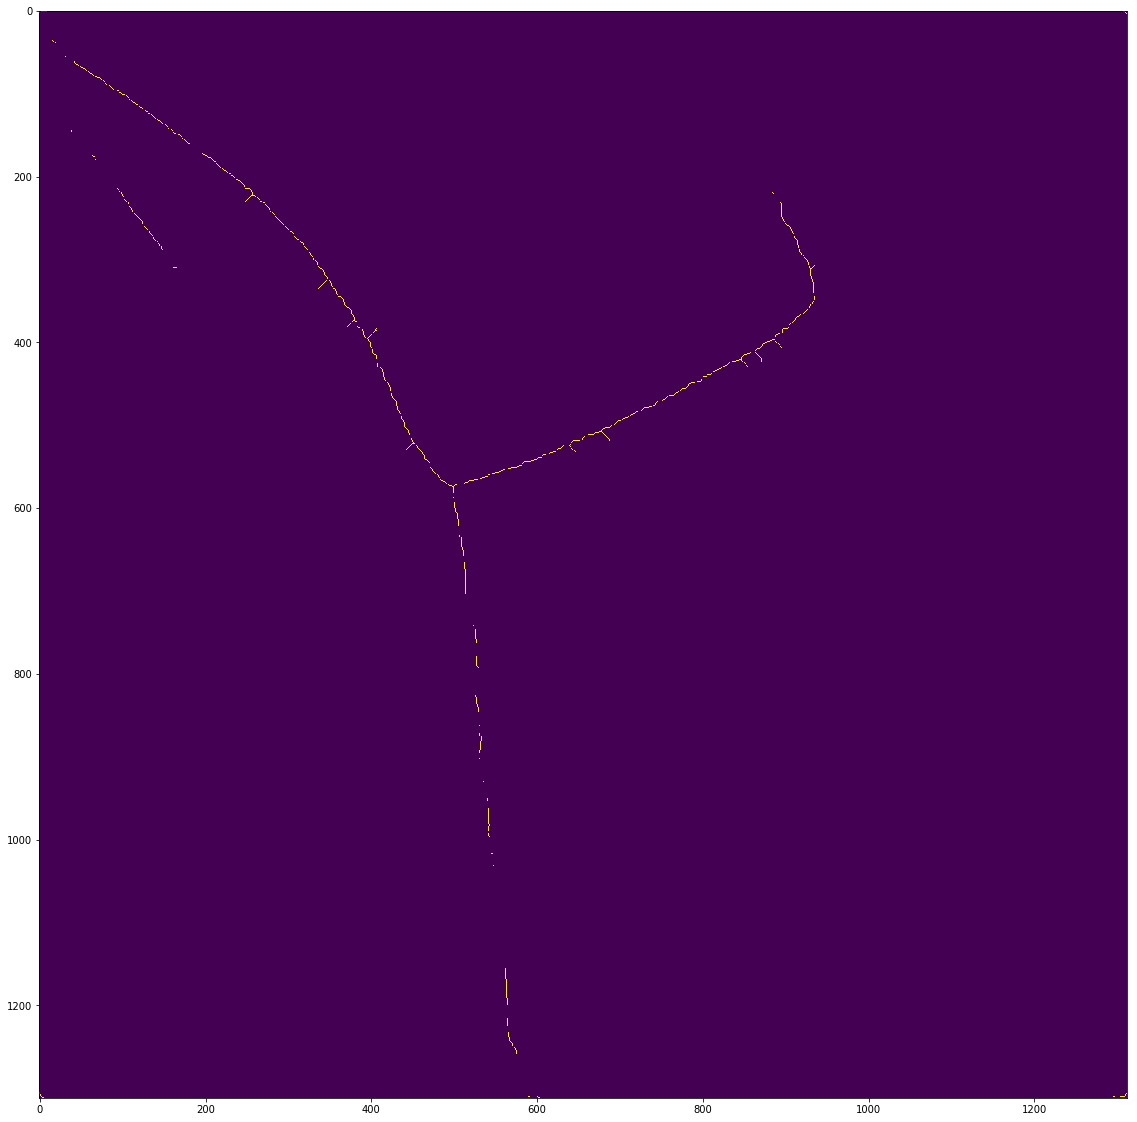

In [23]:
fig=plt.figure(figsize=(20, 20))
plt.imshow(ske)
plt.show()

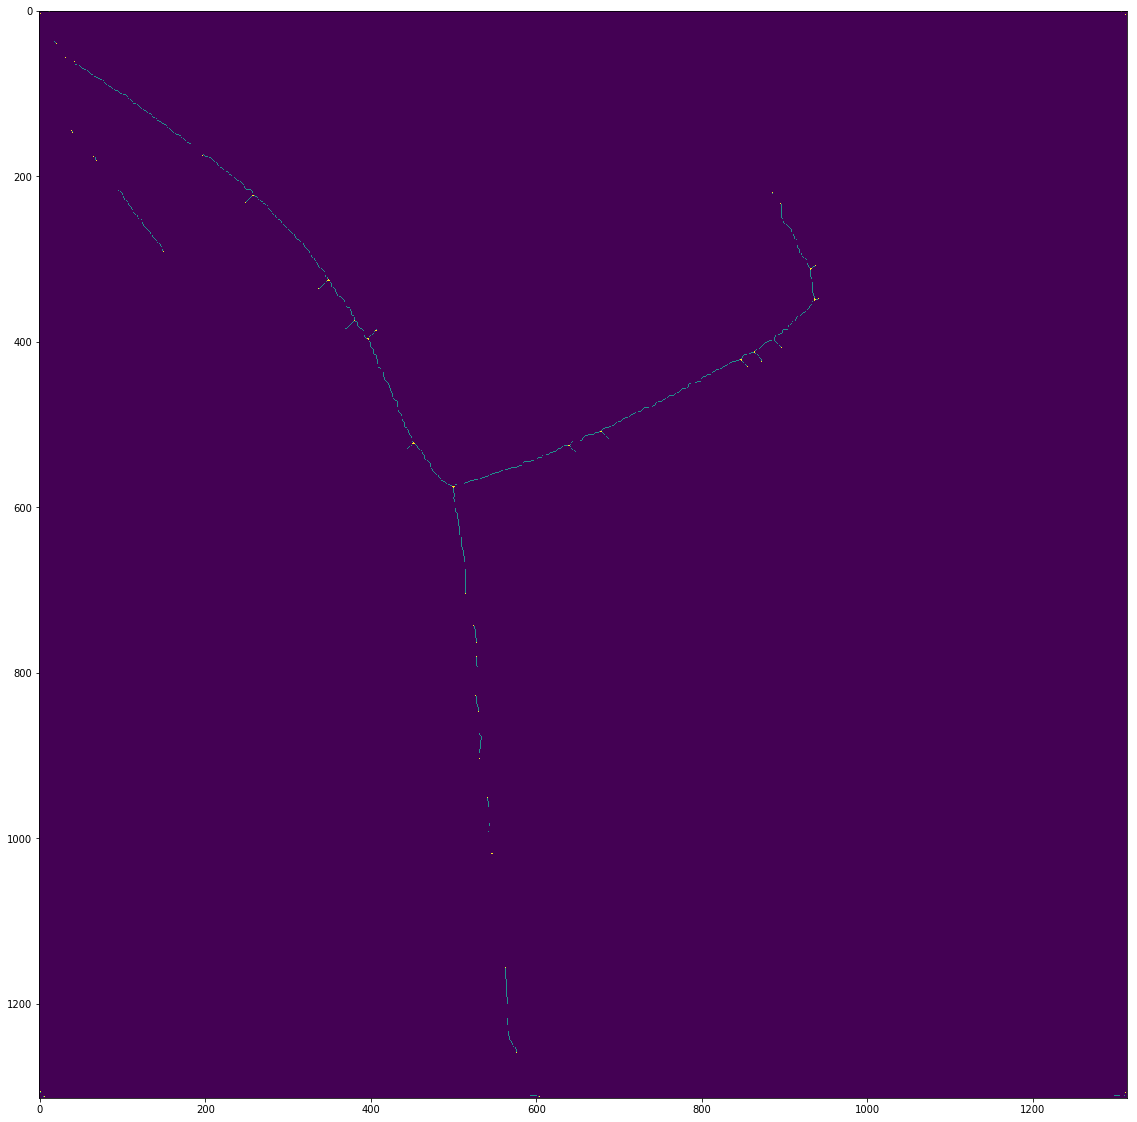

In [37]:
fig=plt.figure(figsize=(20, 20))
buf = buffer(ske)
sknw.mark(buf)
plt.imshow(buf)
plt.show()

In [35]:
buf[590:640,590:640]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [32]:
buf.sum()

1944

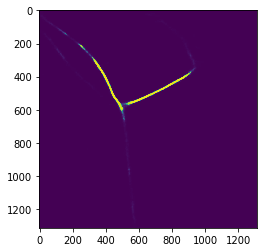

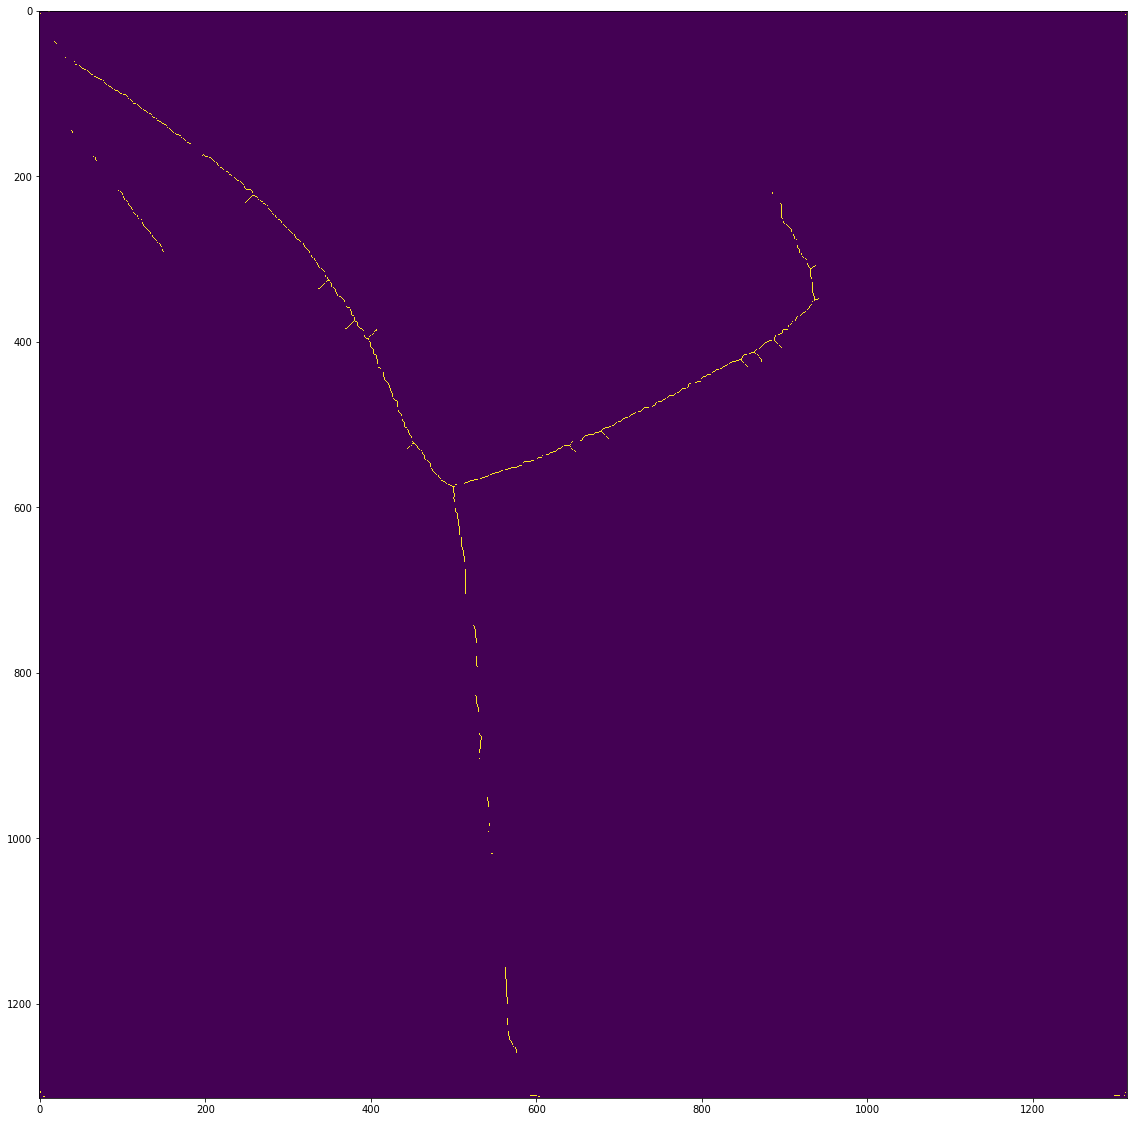

In [29]:
fig=plt.figure(figsize=(20, 20))
buf = buffer(ske)
plt.imshow(buf)
plt.show()

In [15]:
def buffer(ske):
    buf = np.zeros(tuple(np.array(ske.shape)+2), dtype=np.uint16)
    buf[tuple([slice(1,-1)]*buf.ndim)] = ske
    return buf

0 255


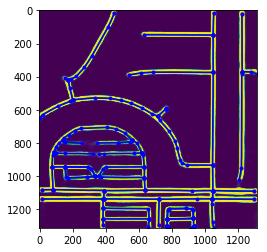

In [7]:
mask_fn = '../data/AOI_2_Vegas_Roads_Test_Public/ln34_wide_masks_mul_ps_vegetation_aug_dice_predict_pad/MUL-PanSharpen_AOI_2_Vegas_img1353.jpg'

img = imread(mask_fn, as_grey=True)
print(np.min(img), np.max(img))

img = skimage.morphology.dilation(img, selem=skimage.morphology.disk(DILATION_SIZE))

img_clip = np.zeros_like(img)
img_clip[img > 255 * CLIP_THRESHOLD] = 1

ske = skimage.morphology.skeletonize(img_clip).astype(np.uint16)
graph = sknw.build_sknw(ske, multi=True)
all_segments = simplify_graph(graph, max_distance=MAX_DISTANCE_FROM_LINE_TO_SPLIT)

plt.imshow(img)

draw_original_graph(graph)

for segments in all_segments:
    plt.plot(segments[:, 1], segments[:, 0], 'blue', marker='.')
plt.show()

0 255


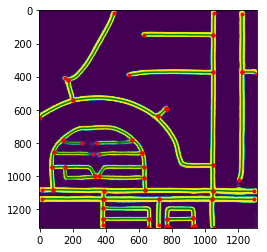

In [9]:
mask_fn = '../data/AOI_2_Vegas_Roads_Test_Public/ln34_wide_masks_mul_ps_vegetation_aug_dice_predict_pad/MUL-PanSharpen_AOI_2_Vegas_img1353.jpg'

img = imread(mask_fn, as_grey=True)
print(np.min(img), np.max(img))

img = skimage.morphology.dilation(img, selem=skimage.morphology.disk(DILATION_SIZE))

img_clip = np.zeros_like(img)
img_clip[img > 255 * CLIP_THRESHOLD] = 1

ske = skimage.morphology.skeletonize(img_clip).astype(np.uint16)
graph = sknw.build_sknw(ske, multi=True)
all_segments = simplify_graph(graph, max_distance=MAX_DISTANCE_FROM_LINE_TO_SPLIT)

plt.imshow(img)

draw_original_graph(graph)
plt.show()
plt.imshow(img)
for segments in all_segments:
    plt.plot(segments[:, 1], segments[:, 0], 'blue', marker='.')
plt.show()

## On city level

In [7]:
solution_df[pd.notnull(solution_df)]

img    t→p    p→t  score
0           AOI_2_Vegas_img1  0.850  0.598  0.702
1          AOI_2_Vegas_img10  0.056  0.194  0.087
2         AOI_2_Vegas_img100  0.895  0.456  0.604
3        AOI_2_Vegas_img1001  0.770  0.604  0.677
4        AOI_2_Vegas_img1002  0.616  0.614  0.615
5        AOI_2_Vegas_img1003  0.957  0.929  0.943
6        AOI_2_Vegas_img1008  0.659  0.812  0.727
7        AOI_2_Vegas_img1012  0.579  0.760  0.657
8        AOI_2_Vegas_img1014  0.506  0.752  0.605
9        AOI_2_Vegas_img1015  0.938  0.578  0.716
10       AOI_2_Vegas_img1018  0.987  0.728  0.838
11        AOI_2_Vegas_img102  0.798  0.366  0.501
12       AOI_2_Vegas_img1020  0.482  0.835  0.611
13       AOI_2_Vegas_img1023  0.767  0.833  0.799
14       AOI_2_Vegas_img1025  0.984  0.986  0.985
15       AOI_2_Vegas_img1027  0.868  0.641  0.737
16       AOI_2_Vegas_img1028  0.768  0.444  0.563
17       AOI_2_Vegas_img1029  0.907  0.674  0.773
18        AOI_2_Vegas_img103  0.939  0.921  0.929
19       AOI_2_Vegas_img1030  0.619  0.592  0.605
20       AOI_2_Vegas_img1032  0.697  0.428  0.530
21       AOI_2_Vegas_img1033  0.648  0.794  0.713
22       AOI_2_Vegas_img1034  0.841  0.886  0.863
23       AOI_2_Vegas_img1035  0.754  0.634  0.688
24       AOI_2_Vegas_img1036  0.935  0.958  0.946
25       AOI_2_Vegas_img1037  0.880  0.868  0.874
26       AOI_2_Vegas_img1038  0.704  0.752  0.727
27       AOI_2_Vegas_img1039  0.219  0.517  0.307
28        AOI_2_Vegas_img104  0.672  0.605  0.637
29       AOI_2_Vegas_img1041  0.949  0.892  0.919
...                      ...    ...    ...    ...
1048545                  NaN  0.001    NaN    NaN
1048546                  NaN  0.336    NaN    NaN
1048547                  NaN  0.021    NaN    NaN
1048548                  NaN  0.006    NaN    NaN
1048549                  NaN  0.077    NaN    NaN
1048550                  NaN  0.036    NaN    NaN
1048551                  NaN  0.000    NaN    NaN
1048552                  NaN  0.552    NaN    NaN
1048553                  NaN  0.004    NaN    NaN
1048554                  NaN  0.399    NaN    NaN
1048555                  NaN  0.036    NaN    NaN
1048556                  NaN  0.001    NaN    NaN
1048557                  NaN  0.314    NaN    NaN
1048558                  NaN  0.000    NaN    NaN
1048559                  NaN  0.000    NaN    NaN
1048560                  NaN  0.443    NaN    NaN
1048561                  NaN  0.486    NaN    NaN
1048562                  NaN  0.652    NaN    NaN
1048563                  NaN  0.291    NaN    NaN
1048564                  NaN  0.850    NaN    NaN
1048565                  NaN  0.014    NaN    NaN
1048566                  NaN  0.003    NaN    NaN
1048567                  NaN  0.693    NaN    NaN
1048568                  NaN  0.952    NaN    NaN
1048569                  NaN  0.000    NaN    NaN
1048570                  NaN  0.576    NaN    NaN
1048571                  NaN  0.000    NaN    NaN
1048572                  NaN  0.026    NaN    NaN
1048573                  NaN  0.754    NaN    NaN
1048574                  NaN  0.001    NaN    NaN

[1048575 rows x 4 columns]

In [8]:
import pandas as pd

solution_df = pd.read_csv('../solutions/score_single_city_1.csv')
solution_df['cty'] = solution_df['img'].apply(lambda x: x.split('_img')[0])

In [9]:
import numpy as np

table = pd.pivot_table(solution_df,
                    index=['cty'],
                    values=["t→p","p→t","score"],
                    aggfunc={np.mean,len},
                    fill_value=0)

table

p→t           score             t→p          
                 len      mean   len      mean   len      mean
cty                                                           
AOI_2_Vegas      989  0.716117   989  0.691610   989  0.712722
AOI_3_Paris      310  0.471319   310  0.293300   310  0.266728
AOI_4_Shanghai  1198  0.265810  1198  0.183509  1198  0.188359
AOI_5_Khartoum   283  0.433943   283  0.326332   283  0.334159

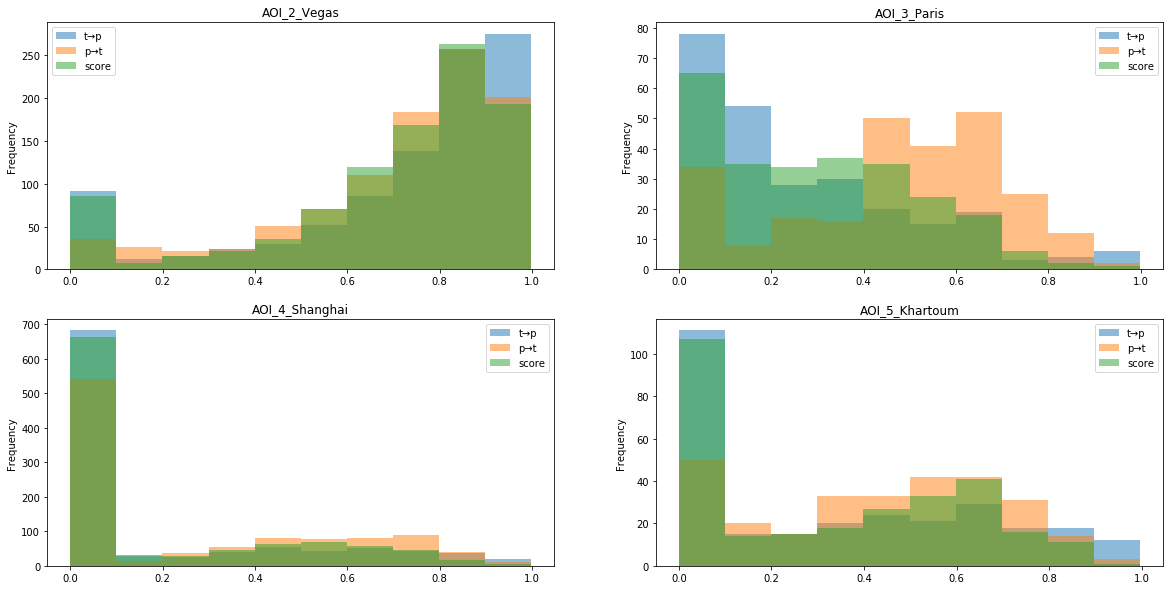

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

solution_df[solution_df.cty == 'AOI_2_Vegas'].plot(kind = 'hist', alpha = 0.5, ax=axes[0,0], title = 'AOI_2_Vegas')
solution_df[solution_df.cty == 'AOI_3_Paris'].plot(kind = 'hist', alpha = 0.5, ax=axes[0,1], title = 'AOI_3_Paris')
solution_df[solution_df.cty == 'AOI_4_Shanghai'].plot(kind = 'hist', alpha = 0.5, ax=axes[1,0], title = 'AOI_4_Shanghai')
solution_df[solution_df.cty == 'AOI_5_Khartoum'].plot(kind = 'hist', alpha = 0.5, ax=axes[1,1], title = 'AOI_5_Khartoum')
plt.show()

In [11]:
import numpy as np
import math
from skimage.io import imread
import matplotlib.pyplot as plt
import skimage.morphology
import sknw
import random 
import networkx as nx

DILATION_SIZE = 4
MAX_DISTANCE_FROM_LINE_TO_SPLIT = 2
CLIP_THRESHOLD = 0.3


def simplify_edge(ps: np.ndarray, max_distance=3):
    """
    Combine multiple points of graph edges to line segments
    so distance from points to segments <= max_distance
    :param ps: array of points in the edge, including node coordinates
    :param max_distance: maximum distance, if exceeded new segment started
    :return: ndarray of new nodes coordinates
    """
    res_points = []
    cur_idx = 0
    # combine points to the single line while distance from the line to any point < max_distance
    for i in range(1, len(ps) - 1):
        segment = ps[cur_idx:i + 1, :] - ps[cur_idx, :]
        angle = -math.atan2(segment[-1, 1], segment[-1, 0])
        ca = math.cos(angle)
        sa = math.sin(angle)
        # rotate all the points so line is alongside first column coordinate
        # and the second col coordinate means the distance to the line
        segment_rotated = np.array([[ca, -sa], [sa, ca]]).dot(segment.T)
        distance = np.max(np.abs(segment_rotated[1, :]))
        if distance > max_distance:
            res_points.append(ps[cur_idx, :])
            cur_idx = i
    if len(res_points) == 0:
        res_points.append(ps[0, :])
    res_points.append(ps[-1, :])

    return np.array(res_points)

def draw_original_graph(graph):
    # draw original points in green/red
    for (s, e) in graph.edges():
        for _, val in graph[s][e].items():
            ps = val['pts']
            plt.plot(ps[:, 1], ps[:, 0], 'green')

            for node in (graph.node[s], graph.node[e]):
                plt.plot(node['o'][1], node['o'][0], 'r.')

def simplify_graph(graph, max_distance=2):
    """
    :type graph: MultiGraph
    """
    all_segments = []
    for (s, e) in graph.edges():
        for _, val in graph[s][e].items():
            ps = val['pts']
            full_segments = np.row_stack([
                graph.node[s]['o'],
                ps,
                graph.node[e]['o']
            ])

            segments = simplify_edge(full_segments, max_distance=max_distance)
            all_segments.append(segments)

    return all_segments

In [32]:
city = 'AOI_5_Khartoum_Roads_Train'
city_filter = 'AOI_5_Khartoum'

# city = 'AOI_4_Shanghai_Roads_Train'
# city_filter = 'AOI_4_Shanghai'

# city_filter = 'AOI_3_Paris'
# city = 'AOI_3_Paris_Roads_Train'

prefix = 'MUL-PanSharpen_'
prefix_rgb = 'RGB-PanSharpen_'
prefix_mul = 'MUL-PanSharpen_'

sample_df = solution_df[(solution_df.cty == city_filter)
                              &((solution_df["score"]) < 0.1)]
                              # &(solution_df.img.isin(['AOI_5_Khartoum_img39']))]

print('Total images fitting this criterion: {}'.format(sample_df.shape[0]))

sample_df = sample_df.sample(n=1)

print(sample_df[["img","t→p","p→t","score"]])


prediction_mask = sample_df.img.values[0]
mask_fn = '../data/' + city + '/ln34_mul_ps_urban_aug_dice_predict_train_for_single_city/' + prefix + prediction_mask + '.jpg'
gt_mask = '../data/' + city + '/RGB-PanSharpen_mask/' + prefix_rgb + prediction_mask + '.jpg'
wide_pred_mask = '../data/' + city + '/ln34_wide_masks_mul_ps_vegetation_aug_dice_predict_train/' + prefix_mul + prediction_mask + '.jpg'
orig_img = '../data/' + city + '/RGB-PanSharpen_8bit/' + prefix_rgb + prediction_mask + '.tif'


gt_mask = imread(gt_mask)
orig_img = imread(orig_img)
wide_pred_mask = imread(wide_pred_mask)

fig=plt.figure(figsize=(20, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(orig_img)

fig.add_subplot(1, 3, 2)
plt.imshow(gt_mask)

fig.add_subplot(1, 3, 3)

img = imread(mask_fn, as_grey=True)
plt.imshow(img)
DILATION_SIZE = 4
MAX_DISTANCE_FROM_LINE_TO_SPLIT = 2
CLIP_THRESHOLD = 0.3

img = skimage.morphology.dilation(img, selem=skimage.morphology.disk(DILATION_SIZE))
img_clip = np.zeros_like(img)
img_clip[img > 255 * CLIP_THRESHOLD] = 1
ske = skimage.morphology.skeletonize(img_clip).astype(np.uint16)

graph = sknw.build_sknw(ske, multi=True)
all_segments = simplify_graph(graph, max_distance=MAX_DISTANCE_FROM_LINE_TO_SPLIT)

draw_original_graph(graph)
for segments in all_segments:
    plt.plot(segments[:, 1], segments[:, 0], 'blue', marker='.')
    

plt.show()

Total images fitting this criterion: 107
                       img  t→p  p→t  score
2755  AOI_5_Khartoum_img64  0.0  0.0    0.0


In [33]:
!rm -rf ../data/AOI_2_Vegas_Roads_Train/vegas_ln34_mul_ps_urban_aug_dice_predict/

rm: cannot remove '../data/AOI_2_Vegas_Roads_Train/vegas_ln34_mul_ps_urban_aug_dice_predict/MUL-PanSharpen_AOI_2_Vegas_img1648.jpg': Permission denied
rm: cannot remove '../data/AOI_2_Vegas_Roads_Train/vegas_ln34_mul_ps_urban_aug_dice_predict/MUL-PanSharpen_AOI_2_Vegas_img30.jpg': Permission denied
rm: cannot remove '../data/AOI_2_Vegas_Roads_Train/vegas_ln34_mul_ps_urban_aug_dice_predict/MUL-PanSharpen_AOI_2_Vegas_img1634.jpg': Permission denied
rm: cannot remove '../data/AOI_2_Vegas_Roads_Train/vegas_ln34_mul_ps_urban_aug_dice_predict/MUL-PanSharpen_AOI_2_Vegas_img627.jpg': Permission denied
rm: cannot remove '../data/AOI_2_Vegas_Roads_Train/vegas_ln34_mul_ps_urban_aug_dice_predict/MUL-PanSharpen_AOI_2_Vegas_img213.jpg': Permission denied
rm: cannot remove '../data/AOI_2_Vegas_Roads_Train/vegas_ln34_mul_ps_urban_aug_dice_predict/MUL-PanSharpen_AOI_2_Vegas_img1548.jpg': Permission denied
rm: cannot remove '../data/AOI_2_Vegas_Roads_Train/vegas_ln34_mul_ps_urban_aug_dice_predict/MUL-Pa